# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


---
# Projet H2023 : Prédiction du prix des diamants


La description du projet est disponible à l'adresse suivante : https://www.kaggle.com/t/2126c40a2d454beb8bd36d168581c968

Ce calepin Jupyter de base permet de charger les données fournies. La dernière section détaille la génération du fichier des prédictions afin de le soumettre sur Kaggle dans le bon format.

### Données

Dans un premier temps, vous devrez récupérer les données sur Kaggle. Les fichiers disponibles sont les suivants :
- train.csv
- test.csv

**Déposez ces fichiers dans le répertoire de ce calepin.**

Le fichier *train.csv* contient le prix de vente en dollar américain de 40 455 diamants en fonction des caractéristiques suivantes :

- cut : qualité de coupe (Fair, Good, Very Good, Premium, Ideal)
- color : couleur du diamant (de J (pire) à D (meilleure)
- clarity : clarté du diamant (I1 (pire), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (meilleure))
- x: longueur en mm 
- y: largeur en mm
- z: profondeur en mm
- depth: pourcentage de la profondeur exprimée comme 2*z/(x+y)
- table: pourcentage de la largeur du sommet du diamant par rapport au point le plus large 

Le fichier test.csv contient les caractéristiques de 13 485 diamants pour lesquels vous devriez prédire le prix de vente. La qualité de vos prédictions sera ensuite évaluée lorsque vous les téléverserez sur Kaggle. Vos prédictions seront comparées à celles des autres équipes de la classe.


### Consignes

- Vous devez constituer une équipe de 3 à 5 personnes.
- Au moins une solution doit être proposée sur Kaggle.
- Utilisez votre identifiant d'équipe pour téléverser vos prédictions sur Kaggle.
- Un seul calepin *.ipynb* par équipe doit être remis. Ce fichier documente et illustre la procédure qui vous a permis de produire vos meilleures prédictions. Ce fichier constitue le rapport final du projet.
- Le langage Julia doit être utilisé.
- Votre démarche doit être rigoureusement justifiée (consultez la grille de correction pour vous orienter).

### Quelques conseils

Votre calepin doit permettre à une personne à l'extérieur de l'équipe de comprendre votre démarche et de reproduire vos résultats. Par exemple, une bonne façon de faire consiste à expliquer dans une cellule de texte la tâche qui est accomplie dans la cellule de code suivante. 

Je vous encourage fortement à faire une analyse exploratoire des données pour développer une meilleure expertise du problème. C'est une étape qui est toujours négligée mais qui est essentielle. C'est avec l'analyse exploratoire que vous viendra des idées d'amélioration, comme par exemple créer de nouvelles variables explicatives.

Vous pouvez utiliser directement tout ce qui se trouve dans les notes de cours sans explication et toutes les librairies utilisées dans le cours (incluant mes fonctions).

Ce calepin contient un modèle très simple de prédiction : on n'utilise qu'une seule variable explicative. Ce sera votre travail d'améliorer ces prédictions avec la méthode et les variables de votre choix.

S'il y a des données manquantes, ce sera à vous de traiter ce problème. Vous devriez développer une méthode d'imputation (de remplacement) des données manquantes.

Prenez la peine de documenter succinctement les essais infructueux. Ce n'est pas nécessaire de les expliquer en détails, mais c'est important de les mentionner dans la discussion avec une raison possible de leur échec. De cette façon, une personne qui reprendra votre travail dans le futur ne perdra pas de temps à réessayer une méthode infructueuse déjà testée.

Vous pouvez aussi indiquer dans votre rapport les raisons qui vous font croire pourquoi une méthode a moins bien performée de ce qui était attendu. Vous pouvez également mentionner ce que vous auriez pu tenter si vous aviez eu plus de temps ou plus de données. L'idée est de guider l'analyste qui prendrait la relève de votre travail.

Vous êtes limités à deux soumissions par jour UTC par équipe sur Kaggle. Je vous suggère donc de bien tester vos modèles localement et de ne téléverser que vos meilleurs prédictions de la journée.

In [313]:
using CSV 
using DataFrames
using Distributions
using Gadfly
using LinearAlgebra
import Random
using GLM
using Statistics
import StatsBase
import Plots

---
## 1. Chargement de données

In [314]:
data = CSV.read("train.csv", DataFrame)
first(data, 5)

5×10 DataFrame
 Row │ ID     cut        color    clarity  depth     table    price  x         ⋯
     │ Int64  String15?  String1  String7  Float64?  Float64  Int64  Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1  missing    E        SI2          60.2     60.0   5340     6.46   ⋯
   2 │     2  Ideal      G        VVS2         62.7     57.0   1936     5.12
   3 │     3  Premium    E        VVS1         62.0     59.0   1012     4.33
   4 │     4  Ideal      G        VS2          61.7     57.0    720     4.41
   5 │     5  missing    G        VS2          62.4     58.0   6301     6.41   ⋯
                                                               2 columns omitted

#### 1.1 Retirer les valeurs aberrantes

In [315]:
filter!((:x) => (x) -> (3 < x), data)
filter!((:y) => (y) -> ismissing(y) || (0 < y && y < 9.5), data)
filter!((:z) => (z) -> (2 < z && z < 6), data)

first(data, 5)

5×10 DataFrame
 Row │ ID     cut        color    clarity  depth     table    price  x         ⋯
     │ Int64  String15?  String1  String7  Float64?  Float64  Int64  Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1  missing    E        SI2          60.2     60.0   5340     6.46   ⋯
   2 │     2  Ideal      G        VVS2         62.7     57.0   1936     5.12
   3 │     3  Premium    E        VVS1         62.0     59.0   1012     4.33
   4 │     4  Ideal      G        VS2          61.7     57.0    720     4.41
   5 │     5  missing    G        VS2          62.4     58.0   6301     6.41   ⋯
                                                               2 columns omitted

In [316]:
Random.seed!(3302)

ntrain = round(Int, 0.8 * nrow(data))

train_id = sample(1:nrow(data), ntrain, replace=false, ordered=true)
valid_id = setdiff(1:nrow(data), train_id)

train = data[train_id, :]
valid = data[valid_id, :]

first(train, 5)

5×10 DataFrame
 Row │ ID     cut        color    clarity  depth     table    price  x         ⋯
     │ Int64  String15?  String1  String7  Float64?  Float64  Int64  Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     2  Ideal      G        VVS2         62.7     57.0   1936     5.12   ⋯
   2 │     3  Premium    E        VVS1         62.0     59.0   1012     4.33
   3 │     4  Ideal      G        VS2          61.7     57.0    720     4.41
   4 │     5  missing    G        VS2          62.4     58.0   6301     6.41
   5 │     7  Very Good  D        SI1          60.2     61.0    571     4.39   ⋯
                                                               2 columns omitted

In [317]:
nrow(data), nrow(train), nrow(valid)

(40425, 32340, 8085)

---
## 2. Analyse exploratoire

Cette section consitue une analyse exploratoire superficielle permettant de se familiariser avec les données. C'est une analyse exploratoire sommaire. Je vous encourage fortement à poursuivre cette analyse.

#### 2.1 Prix en fonction de la longeur

J'ai utilisé la librairie Plots pour alléger les graphiques, mais ça reste exigeant en mémoire pour le calepin. Il y en effet 40 455 points !

In [318]:
# p1 = Plots.plot(data.x, data.price, seriestype=:scatter, label="")
# Plots.xlabel!("x (en mm)")
# Plots.ylabel!("prix")

# p2 = Plots.plot(data.y, data.price, seriestype=:scatter, label="")
# Plots.xlabel!("y (en mm)")
# Plots.ylabel!("prix")

# p3 = Plots.plot(data.z, data.price, seriestype=:scatter, label="")
# Plots.xlabel!("z (en mm)")
# Plots.ylabel!("prix")

# Plots.plot(p1, p2, p3, layout = 3)

#### 2.2 Prix en fonction de la clarté

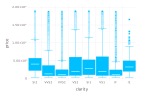

In [319]:
plot(data, x=:clarity, y=:price, Geom.boxplot)

min price = 326, max price = 18823
min y = 3.67, max y = 9.46


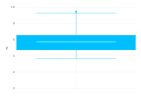

In [320]:
data_without_missing_y = dropmissing(data, :y, disallowmissing=true)
println("min price = $(minimum(data.price)), max price = $(maximum(data.price))")
println("min y = $(minimum(data_without_missing_y.y)), max y = $(maximum(data_without_missing_y.y))")
plot(data_without_missing_y, y=:y, Geom.boxplot)

In [321]:
data.chart = [price_chart[data[i, :color]][clarity_to_column[data[i, :clarity]]] for i = 1:nrow(data)]
data.color_num = [color_to_row[color] for color = data.color]
data.clarity_num = [clarity_to_column[clarity] for clarity = data.clarity]

# cor(Matrix(select(data, [:table, :x, :z, :price])))
# cor(Matrix(dropmissing(select(data, [:depth, :table, :x, :y, :z, :price]))))
cor(Matrix(dropmissing(select(data, [:x, :z, :chart, :color_num, :clarity_num, :price]))))


6×6 Matrix{Float64}:
  1.0        0.991571  -0.428452   0.269967    0.36833     0.886909
  0.991571   1.0       -0.434113   0.274719    0.372463    0.882392
 -0.428452  -0.434113   1.0       -0.499778   -0.800437   -0.181887
  0.269967   0.274719  -0.499778   1.0        -0.0222731   0.171161
  0.36833    0.372463  -0.800437  -0.0222731   1.0         0.137941
  0.886909   0.882392  -0.181887   0.171161    0.137941    1.0

In [322]:
describe(data)

13×7 DataFrame
 Row │ variable     mean     min   median   max        nmissing  eltype        ⋯
     │ Symbol       Union…   Any   Union…   Any        Int64     Type          ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ID           20228.3  1     20228.0  40455             0  Int64         ⋯
   2 │ cut                   Fair           Very Good      3804  Union{Missing
   3 │ color                 D              J                 0  String1
   4 │ clarity               I1             VVS2              0  String7
   5 │ depth        61.7475  42.2  61.8     100.5          2199  Union{Missing ⋯
   6 │ table        57.4649  43.0  57.0     95.0              0  Float64
   7 │ price        3934.35  326   2402.0   18823             0  Int64
   8 │ x            5.73137  3.73  5.7      9.5               0  Float64
   9 │ y            5.7329   3.67  5.71     9.46           2199  Union{Missing ⋯
  10 │ z            3.5392   2.06  3.52     5.98              0  Float64
  11 │ chart        34.4082  14    34.0     80                0  Int64
  12 │ color_num    2.5955   0     3.0      6                 0  Int64
  13 │ clarity_num  4.96166  1     5.0      9                 0  Int64         ⋯
                                                                1 column omitted

---
## 3. Ajustement d'un modèle de régression linéaire

Pour cet exemple simple, on n'utilise que la longueur du diamant pour prédire le prix dans un modèle de régression quadratique.

#### A Sample Diamond Price Chart

[source](https://www.gemsociety.org/article/what-determines-diamond-cost/)

<table class="dv5Tq"><tbody><tr><td colspan="12"><b><span class="Apple-converted-space">&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; </span>(0.46-0.49 CTS) <span class="Apple-converted-space">&nbsp; &nbsp; &nbsp; &nbsp; </span>DATE<span class="Apple-converted-space">&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; </span>ROUNDS <span class="Apple-converted-space">&nbsp; &nbsp; &nbsp;</span></b></td></tr><tr><td colspan="1"></td><td colspan="1"><b>IF</b></td><td colspan="1"><b>VVS1</b></td><td colspan="1"><b>VVS2</b></td><td colspan="1"><b>VS1</b></td><td colspan="1"><b>VS2</b></td><td colspan="1"><b>SI1</b></td><td colspan="1"><b>SI2</b></td><td colspan="1"><b>SI3</b></td><td colspan="1"><b>I1</b></td><td colspan="1"><b>I2</b></td><td colspan="1"><b>I3</b></td></tr><tr><td colspan="1"><b>D</b></td><td colspan="1">80</td><td colspan="1">65</td><td colspan="1">59</td><td colspan="1">49</td><td colspan="1">40</td><td colspan="1">34</td><td colspan="1">27</td><td colspan="1">24</td><td colspan="1">21</td><td colspan="1">15</td><td colspan="1">11</td></tr><tr><td colspan="1"><b>E</b></td><td colspan="1">65</td><td colspan="1">60</td><td colspan="1">51</td><td colspan="1">46</td><td colspan="1">39</td><td colspan="1">33</td><td colspan="1">26</td><td colspan="1">23</td><td colspan="1">20</td><td colspan="1">14</td><td colspan="1">10</td></tr><tr><td colspan="1"><b>F</b></td><td colspan="1">60</td><td colspan="1">52</td><td colspan="1">46</td><td colspan="1">43</td><td colspan="1">37</td><td colspan="1">31</td><td colspan="1">25</td><td colspan="1">22</td><td colspan="1">19</td><td colspan="1">13</td><td colspan="1">10</td></tr><tr><td colspan="1"><b>G</b></td><td colspan="1">52</td><td colspan="1">46</td><td colspan="1">42</td><td colspan="1">40</td><td colspan="1">35</td><td colspan="1">29</td><td colspan="1">24</td><td colspan="1">21</td><td colspan="1">18</td><td colspan="1">13</td><td colspan="1">9</td></tr><tr><td colspan="1"><b>H</b></td><td colspan="1">44</td><td colspan="1">40</td><td colspan="1">36</td><td colspan="1">34</td><td colspan="1">30</td><td colspan="1">27</td><td colspan="1">22</td><td colspan="1">19</td><td colspan="1">17</td><td colspan="1">12</td><td colspan="1">9</td></tr><tr><td colspan="1"><b>I</b></td><td colspan="1">35</td><td colspan="1">32</td><td colspan="1">30</td><td colspan="1">27</td><td colspan="1">25</td><td colspan="1">23</td><td colspan="1">21</td><td colspan="1">18</td><td colspan="1">16</td><td colspan="1">12</td><td colspan="1">9</td></tr><tr><td colspan="1"><b>J</b></td><td colspan="1">29</td><td colspan="1">27</td><td colspan="1">25</td><td colspan="1">24</td><td colspan="1">23</td><td colspan="1">22</td><td colspan="1">20</td><td colspan="1">17</td><td colspan="1">14</td><td colspan="1">12</td><td colspan="1">8</td></tr><tr><td colspan="1"><b>K</b></td><td colspan="1">23</td><td colspan="1">22</td><td colspan="1">21</td><td colspan="1">20</td><td colspan="1">19</td><td colspan="1">18</td><td colspan="1">16</td><td colspan="1">15</td><td colspan="1">13</td><td colspan="1">11</td><td colspan="1">8</td></tr><tr><td colspan="1"><b>L</b></td><td colspan="1">22</td><td colspan="1">21</td><td colspan="1">20</td><td colspan="1">19</td><td colspan="1">18</td><td colspan="1">17</td><td colspan="1">15</td><td colspan="1">13</td><td colspan="1">11</td><td colspan="1">10</td><td colspan="1">7</td></tr><tr><td colspan="1"><b>M</b></td><td colspan="1">18</td><td colspan="1">17</td><td colspan="1">17</td><td colspan="1">16</td><td colspan="1">15</td><td colspan="1">14</td><td colspan="1">13</td><td colspan="1">11</td><td colspan="1">10</td><td colspan="1">9</td><td colspan="1">6</td></tr></tbody></table>

In [323]:
d = [80, 65, 59, 49, 40, 34, 27, 24, 21, 15, 11]
e = [65, 60, 51, 46, 39, 33, 26, 23, 20, 14, 10]
f = [60, 52, 46, 43, 37, 31, 25, 22, 19, 13, 10]
g = [52, 46, 42, 40, 35, 29, 24, 21, 18, 13,  9]
h = [44, 40, 36, 34, 30, 27, 22, 19, 17, 12,  9]
i = [35, 32, 30, 27, 25, 23, 21, 18, 16, 12,  9]
j = [29, 27, 25, 24, 23, 22, 20, 17, 14, 12,  8]
k = [23, 22, 21, 20, 19, 18, 16, 15, 13, 11,  8]
l = [22, 21, 20, 19, 18, 17, 15, 13, 11, 10,  7]
m = [18, 17, 17, 16, 15, 14, 13, 11, 10,  9,  6]

price_chart = Dict(
    "D" => d,
    "E" => e,
    "F" => f,
    "G" => g,
    "H" => h,
    "I" => i,
    "J" => j,
    "K" => k,
    "L" => l,
    "M" => m,
)

clarity_to_column = Dict(
    "IF"   => 1,
    "VVS1" => 2,
    "VVS2" => 3,
    "VS1"  => 4,
    "VS2"  => 5,
    "SI1"  => 6,
    "SI2"  => 7,
    "I1"   => 9,
)

color_to_row = Dict(
    "D" => 0,
    "E" => 1,
    "F" => 2,
    "G" => 3,
    "H" => 4,
    "I" => 5,
    "J" => 6,
    "K" => 7,
    "L" => 8,
    "M" => 9,
)

# train.chart = [price_chart[train[i, :color]][clarity_to_column[train[i, :clarity]]] for i = 1:nrow(train)]
# train.color_num = [color_to_row[color] for color = train.color]
# train.clarity_num = [clarity_to_column[clarity] for clarity = train.clarity]

# first(train, 5)

Dict{String, Int64} with 10 entries:
  "L" => 8
  "I" => 5
  "J" => 6
  "M" => 9
  "D" => 0
  "G" => 3
  "E" => 1
  "K" => 7
  "F" => 2
  "H" => 4

#### Distribution de y

min y = 3.67, max y = 9.43


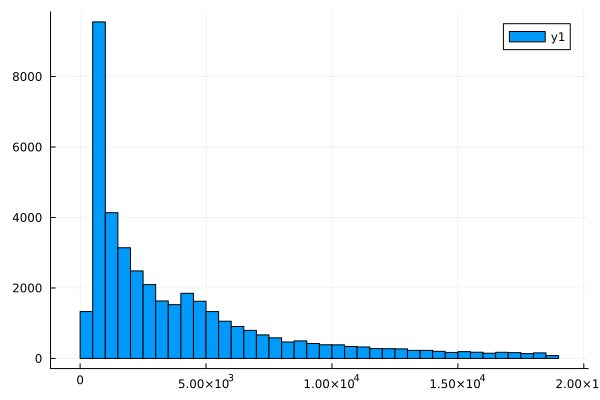

In [324]:
train_without_missing_y = dropmissing(train, :y, disallowmissing=true)
println("min y = $(minimum(train_without_missing_y.y)), max y = $(maximum(train_without_missing_y.y))")
# plot(train_without_missing_y, y=:y, Geom.boxplot)
# Plots.histogram(train_without_missing_y.y)
Plots.histogram(data.price)


#### 3.3 Prédire les y avec une loi linéaire généralisée gamma

In [325]:
# model = glm(@formula(y ~ color * clarity * table * x * z), train, Normal(), IdentityLink())
y_model = glm(@formula(y ~ color * clarity * table * x * z), train, Gamma(), InverseLink())
train.y = coalesce.(train.y, predict(y_model, train))
valid.y = coalesce.(valid.y, predict(y_model, valid))

# plot_predictions(dropmissing(train).y, predict(model, dropmissing(train)))

# cut_model = glm(@formula(cut ~ color * clarity * table * x * z), train, Gamma(), InverseLink())
# train.cut = coalesce.(train.cut, predict(cut_model, train))

8085-element Vector{Float64}:
 6.5
 4.42
 5.78
 6.31
 4.32
 5.75
 4.83
 6.39
 5.32
 6.53
 ⋮
 7.31
 6.49
 8.42
 7.01
 4.74
 5.36
 5.12
 5.26
 4.28

#### 3.4 Recalculer depth avec les nouvelles valeurs de y

In [326]:
# train.depth = 100 * 2 .* train.z ./ (train.x .+ train.y)
# Supprimer depth
# first(select!(train, Not(:depth)), 5)

In [327]:
print(nrow(train))
# dropmissing!(train)
nrow(train)

32340

32340

In [328]:
# https://juliastats.org/GLM.jl/stable/
model = glm(@formula(price ~ color * clarity + x * y * z), train, Normal(), IdentityLink())
# model = glm(@formula(price ~ color * clarity * x * y * z), train, Gamma(), InverseLink())
# model = glm(@formula(price ~ color * clarity + x * y * z), train, Poisson(), LogLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Normal{Float64}, IdentityLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

price ~ 1 + color + clarity + x + y + z + color & clarity + x & y + x & z + y & z + x & y & z

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────
                                 Coef.  Std. Error       z  Pr(>|z|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                29372.1       869.115     33.80    <1e-99   27668.6      31075.5
color: E                    -295.614     256.602     -1.15    0.2493    -798.546      207.317
color: F                    -180.97      241.63      -0.75    0.4539    -654.555      292.616
color: G                    -640.359     240.862     -2.66    0.0078   -1112.44      -168.279
color: H     

In [329]:
# Extraction de l'estimation des coefficients
β̂ = coef(model)

63-element Vector{Float64}:
 29372.083660747805
  -295.6142015321808
  -180.9698562256508
  -640.359283236479
 -1788.04873626103
 -1586.6841466549515
 -3169.6215489971837
  8172.372019846872
  2969.0763385049395
  2161.160408716954
     ⋮
  -119.36472826501424
   125.0922650209192
   579.4311216311353
    20.32673774459328
   609.0845636622256
  1138.87294769289
 -2885.033277217816
  4956.41556386229
  -131.44294856829472

#### 3.2. Validation graphique

Pour avoir un aperçu de la qualité de la regression, on ajoute la droite de régression.

---
## 4. Estimation du prix de diamants de l'ensemble de test

On utilise le modèle simple de la section précédente pour estimer le prix de chacun des diamants de l'ensemble de test.

#### 4.1 Chargement des données de l'ensemble de test

In [330]:
test = CSV.read("test.csv", DataFrame)
first(test, 5)

5×9 DataFrame
 Row │ ID     cut        color    clarity  depth     table    x        y       ⋯
     │ Int64  String15?  String1  String7  Float64?  Float64  Float64  Float64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1  Ideal      G        VS2          62.5     56.0     6.41      6.3 ⋯
   2 │     2  Ideal      G        VS2          61.7     55.0     5.75      5.7
   3 │     3  Premium    F        SI1          62.1     58.0     5.7       5.6
   4 │     4  missing    J        VS2          62.3     57.0     4.38      4.3
   5 │     5  Premium    G        SI2          60.6     59.0     8.36      8.3 ⋯
                                                               2 columns omitted

In [331]:
nrow(test), nrow(dropmissing(test))

(13485, 11491)

#### 4.2 Ajout d'une colonne pour le carré de la longueur

#### 4.3 Prédiction

In [332]:
predictions = predict(model, train)
predictions = round.(Int, predictions)

rmse = StatsBase.rmsd(predictions, train.price)

1050.6716627709663

In [337]:
# valid.y = coalesce.(valid.y, mean(skipmissing(data.y)))
# valid.y = coalesce.(valid.y, predict())

select!(valid, [:color, :clarity, :x, :y, :z, :price])

predictions = predict(model, valid)
# mean_price = mean(train.price)
# predictions = [if ismissing(p) mean_price else p end for p in predictions]
# predictions = round.(Int, predictions)
# clamp!(predictions, minimum(data.price), maximum(data.price))

# rmse = StatsBase.rmsd(predictions, valid.price)
# first(valid, 5)
model

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Normal{Float64}, IdentityLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

price ~ 1 + color + clarity + x + y + z + color & clarity + x & y + x & z + y & z + x & y & z

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────
                                 Coef.  Std. Error       z  Pr(>|z|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                29372.1       869.115     33.80    <1e-99   27668.6      31075.5
color: E                    -295.614     256.602     -1.15    0.2493    -798.546      207.317
color: F                    -180.97      241.63      -0.75    0.4539    -654.555      292.616
color: G                    -640.359     240.862     -2.66    0.0078   -1112.44      -168.279
color: H     

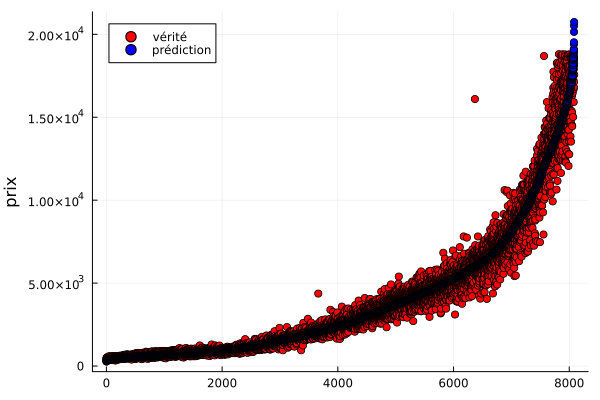

In [295]:
function plot_predictions(predictions, real_price)
    df = DataFrame(predictions=predictions, real_price=real_price)
    sort!(df, [:predictions])
    # sort!(df, [:real_price])

    range = 1:length(predictions)
    # range = 1:1000

    Plots.plot(range, df.real_price[range], seriestype=:scatter, color=:red, label="vérité")
    Plots.plot!(range, df.predictions[range], seriestype=:scatter, color=:blue, label="prédiction")
    # Plots.xlabel!("# rangée (en ordre croissant de prédiction de prix)")
    Plots.ylabel!("prix")
end

plot_predictions(predictions, valid.price)

In [52]:
predictions = predict(model, test)
mean_price = mean(train.price)
predictions = [if ismissing(p) mean_price else p end for p in predictions]
predictions = round.(Int, predictions)

minimum(predictions), maximum(predictions)

(0, 4609157873484)

In [30]:
outliers = filter(price -> price < minimum(data.price) || price > maximum(data.price), predictions)
clamp!(predictions, minimum(data.price), maximum(data.price))
outliers

113-element Vector{Int64}:
   323
 23303
   306
 19179
 23728
 20230
 26344
   324
 21483
 20145
     ⋮
 20999
 21790
 20752
 20662
 19267
 19358
 19732
 20612
 21584

#### 4.3 Préparation du fichier des préditions pour téléverser sur Kaggle

Le fichier *benchmark_predictions.csv* généré peut être téléversé sur Kaggle. Il est composé d'une colonne d'identifiants (:ID) et d'une colonne de la prédiction des prix (:price).

In [ ]:
benchmark_predictions = DataFrame(ID = test.ID, price=predictions)
first(benchmark_predictions, 5)

In [ ]:
CSV.write("benchmark_predictions.csv", benchmark_predictions)